In [19]:
!pip install torch torchvision
!pip install transformers datasets
!pip install transformers[torch]
!pip install matplotlib
!pip install scikit-learn
!pip install --upgrade transformers

In [20]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [21]:
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']
trainds, valds, testds

(Dataset({
     features: ['img', 'label'],
     num_rows: 4500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 500
 }),
 Dataset({
     features: ['img', 'label'],
     num_rows: 1000
 }))

In [22]:
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

bird


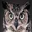

In [23]:
index = 0
img, lab = trainds[index]['img'], itos[trainds[index]['label']]
print(lab)
img

In [24]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name) 

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

In [25]:
norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
]) 

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [26]:
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

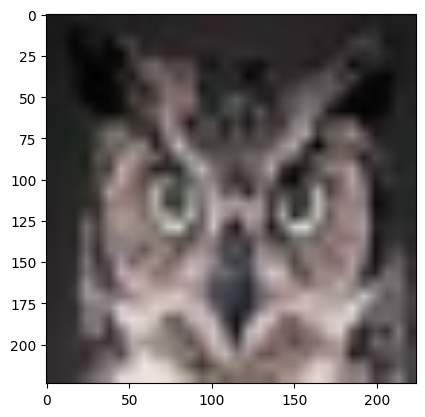

In [27]:
idx = 0
ex = trainds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [28]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier)

Linear(in_features=768, out_features=1000, bias=True)


In [29]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=10, bias=True)


In [31]:
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    eval_strategy ="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

In [32]:
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [33]:
trainer = Trainer(
    model,
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/tmp/ipykernel_2816/2952389733.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.072384,0.980000
2,0.392000,0.073449,0.980000
3,0.022600,0.072527,0.978000


TrainOutput(global_step=1350, training_loss=0.155159996703819, metrics={'train_runtime': 1119.8275, 'train_samples_per_second': 12.055, 'train_steps_per_second': 1.206, 'total_flos': 1.046216869705728e+18, 'train_loss': 0.155159996703819, 'epoch': 3.0})

In [35]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 0.08279206603765488, 'test_accuracy': 0.975, 'test_runtime': 27.7808, 'test_samples_per_second': 35.996, 'test_steps_per_second': 8.999}


In [36]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('cat', 'cat')

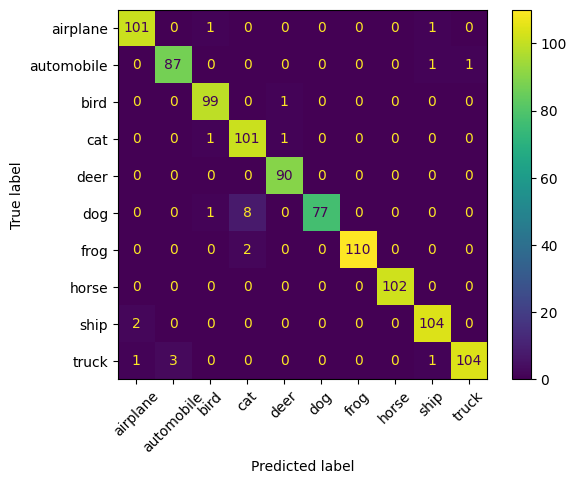

In [37]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)